In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import joblib


In [18]:
#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [19]:
train_dir = r"D:\computer vision\CV_Tasks-main\CV_Tasks-main\Alzheimer_s Dataset\Alzheimer_s Dataset\Alzheimer_s Dataset\Alzheimer_s Dataset\train"
test_dir = r"D:\computer vision\CV_Tasks-main\CV_Tasks-main\Alzheimer_s Dataset\Alzheimer_s Dataset\Alzheimer_s Dataset\Alzheimer_s Dataset\test"

In [20]:
# Set the input shape
input_shape = (128, 128, 3)
batch_size = 32

In [21]:
# Use ImageDataGenerator for data augmentation
data_generator = ImageDataGenerator(rescale=1./255)

In [22]:
# Load the training images
train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 5121 images belonging to 4 classes.


In [23]:
# Load the test images
test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 1279 images belonging to 4 classes.


In [24]:
# Define the model architecture up to the feature extraction layer
model = Sequential([
    Conv2D(32, (3, 3), input_shape=input_shape),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64),
    Activation('relu'),
    Dropout(0.5)
])

In [25]:
# Extract features from training images 
train_features = model.predict(train_generator)
train_features = train_features.reshape(train_features.shape[0], -1)  # Flatten features for classifier
train_labels = train_generator.classes

161/161 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step


In [26]:
# Extract features from test images 
test_features = model.predict(test_generator)
test_features = test_features.reshape(test_features.shape[0], -1)
test_labels = test_generator.classes

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step


In [28]:
# Initialize and train AdaBoost classifier
ada_classifier = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), 
                                    n_estimators=50,
                                    learning_rate=1.0,
                                    algorithm='SAMME')
ada_classifier.fit(train_features, train_labels)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1))

In [29]:
# Make predictions on the test data
test_predictions = ada_classifier.predict(test_features)

In [30]:
# Calculate accuracy
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 51.76%


In [32]:
# Save the Keras CNN model as an .h5 file
model.save('models/cnn_feature_extractor7.h5')

In [33]:
# Save the trained AdaBoost model
joblib.dump(ada_classifier, 'ada_classifier.pkl')

['ada_classifier.pkl']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


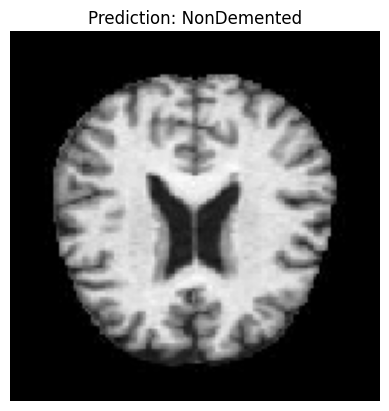

The image is classified as: NonDemented


In [36]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import joblib
import numpy as np
from tensorflow.keras.preprocessing import image

cnn_model = load_model("models/cnn_feature_extractor7.h5")
dt_classifier = joblib.load("models/ada_classifier.pkl")

def classify_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    features = cnn_model.predict(img_array)
    features = features.reshape(1, -1)

    prediction = dt_classifier.predict(features)
    
    class_labels = {0: 'MildDemented', 1: 'ModerateDemented', 2: 'NonDemented', 3: 'VeryMildDemented'}
    result = class_labels[prediction[0]]
    
    plt.imshow(img)
    plt.title(f"Prediction: {result}")
    plt.axis('off')
    plt.show()

    return result

img_path = r"D:\computer vision\CV_Tasks-main\CV_Tasks-main\Alzheimer_s Dataset\Alzheimer_s Dataset\Alzheimer_s Dataset\Alzheimer_s Dataset\test\NonDemented\26 (62).jpg"
result = classify_image(img_path)
print(f"The image is classified as: {result}")
